In [1]:
from datasets.dtu import DTUDataset
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

torch.backends.cudnn.benchmark = True # this increases inference speed a little

# Load pretrained model

In [105]:
from models.mvsnet import CascadeMVSNet
from utils import load_ckpt
from inplace_abn import ABN
model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      use_attention=False,
                      use_atv=True,
                      norm_act=ABN).cuda()
load_ckpt(model, 'ckpts/exp2/_ckpt_epoch_10.ckpt')
# load_ckpt(model, 'ckpts/exp2_g8/_ckpt_epoch_48.ckpt')
# load_ckpt(model, 'ckpts/exp_g8_atv/_ckpt_epoch_5.ckpt')
model.eval();

In [106]:
dataset = DTUDataset('/home/ubuntu/data/DTU/mvs_training/dtu/', 'test', n_views=5, depth_interval=2.65,
                     img_wh=(768, 576))

In [107]:
def decode_batch(batch):
    imgs = batch['imgs']
    proj_mats = batch['proj_mats']
    depths = batch['depths']
    masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

imgs, proj_mats, depths, masks, init_depth_min, depth_interval = decode_batch(dataset[120])
unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

# Visualize an example depth

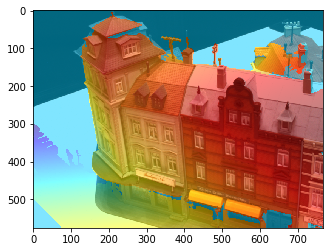

In [108]:
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(depths['level_0']*masks['level_0']).permute(1,2,0), alpha=0.5)

# Do inference on this sample

In [109]:
t = time.time()
with torch.no_grad():
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)

inference time 0.2128605842590332


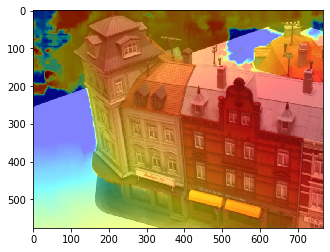

In [110]:
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.5)

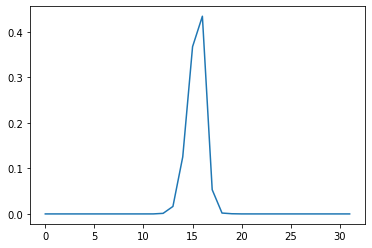

In [130]:
plt.plot(results['prob_volume_1'][0, :, 100*2, 100*2].cpu().numpy())

In [112]:
results['depth_std_1'][0, 200, 200]*2*1.5/16

tensor(0.0761, device='cuda:0')

In [113]:
results['depth_interval_0'][0, 0, 100*4, 100*4]

tensor(0.1569, device='cuda:0')

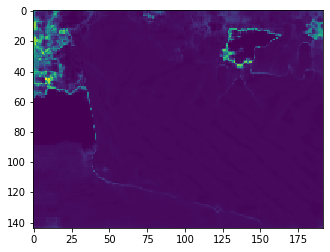

In [114]:
plt.imshow(results['depth_std_2'][0].cpu().numpy())

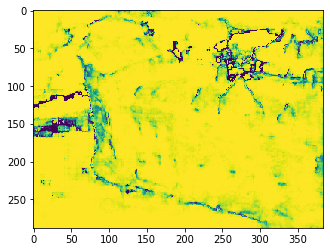

In [124]:
plt.imshow(results['confidence_1'][0].cpu().numpy())

In [116]:
depth_exp = results['depth_0'][0].cpu().numpy()
depth_std = cv2.resize(results['depth_std_1'][0].cpu().numpy(), None, fx=2, fy=2)
depth_interval = results['depth_interval_0'][0][0].cpu().numpy()
# mask = (depths['level_0'].numpy() < depth_exp+1.5*depth_std) & (depths['level_0'].numpy()-depth_exp>-1.5*depth_std)
mask = (depths['level_0'].numpy() < depth_exp+4*depth_interval) & (depths['level_0'].numpy()-depth_exp>-4*depth_interval)

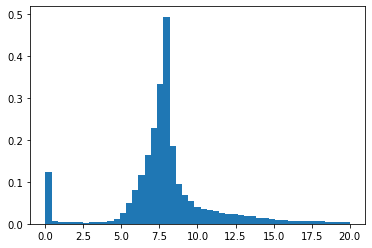

In [117]:
plt.hist(16*results['depth_interval_1'][0][0].cpu().numpy().flatten(), bins=np.linspace(0,20,50), density=True);

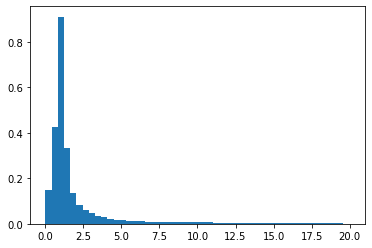

In [118]:
plt.hist(8*results['depth_interval_0'][0][0].cpu().numpy().flatten(), bins=np.linspace(0,20,50), density=True);

0.2037692599826389

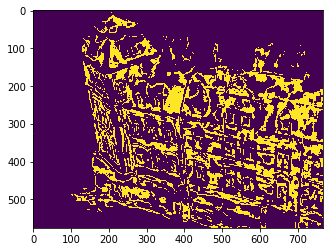

In [119]:
plt.imshow(mask)
mask.mean()

(array([   97.,  1462., 15209.,  1783.,   528.,   104.,    47.,    28.,
           18.,    44.]),
 array([3.2541604e-04, 2.0002928e+00, 4.0002604e+00, 6.0002279e+00,
        8.0001955e+00, 1.0000163e+01, 1.2000130e+01, 1.4000097e+01,
        1.6000065e+01, 1.8000032e+01, 2.0000000e+01], dtype=float32),
 <a list of 10 Patch objects>)

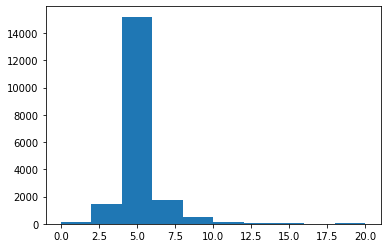

In [120]:
a = results['depth_std_2'][0].cpu().numpy()[masks['level_2']]
a[a>20] = 20
plt.hist(a)

(array([ 2390., 49458., 14798.,  3872.,  2111.,  1381.,   765.,   463.,
          332.,  1939.]),
 array([3.3033130e-04, 2.0029730e-01, 4.0026426e-01, 6.0023123e-01,
        8.0019820e-01, 1.0001652e+00, 1.2001321e+00, 1.4000992e+00,
        1.6000661e+00, 1.8000331e+00, 2.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

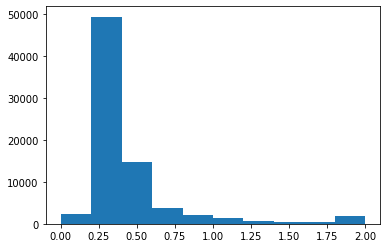

In [121]:
a = results['depth_std_1'][0].cpu().numpy()[masks['level_1']]
a[a>2] = 2
plt.hist(a)

# Reference: show pixels whose absolute depth error is less than 2mm

acc_2mm : 0.6805657744407654


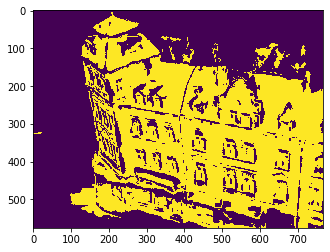

In [122]:
err2 = torch.abs(depths['level_0']-results['depth_0'].cpu())[0]<2
plt.imshow(err2);
print('acc_2mm :', ((err2.float()*masks['level_0']).sum()/masks['level_0'].sum()).item())